## imports

In [0]:
import operator
import time
import matplotlib.pyplot as plt

## read map

In [298]:
smap = open('test1').read()
print(smap)

%%%%%%%%%%%%%
%    %2%    %
%   3Q      %
% %%%%% %%%%%
%1      % % %
%%% %%  %1% %
%    %    % %
%3     P%   %
% % %%%  %% %
%   %1      %
%%%%%%%%%%%%%


با استفاده از دستور اوپن نقشه ی داده شده در تست کیس ها را می خوانیم.

## define rows and columns

In [0]:
  row = 0
  col = 0
  colbool = False
  for i in range(len(smap)):
    if smap[i] == '\n':
      if colbool == False:
        colbool = True
        col = i
      row += 1
  row += 1
  col += 1

برای اینکه بتوانیم غذاها و دیوارها و ایجنت ها را مشخص کنیم نیاز به مختصات این المان ها داریم. برای اینکه بتوانیم مختصات آن ها را پیدا کنیم باید تعداد سطر و ستون نقشه مان را بدانیم. بنابراین در این تابع با استفاده از تعداد خط های جدید که در رشته ی نقشه ی خوانده شده از تست کیس ها آمده است تعداد سطر و ستون را پیدا می کنیم.

## define steps

In [0]:
steps = [(1,0), (0,1), (-1,0), (0,-1)]

برای اینکه در توابع جلوتر بتوانم خانه های کنار ایجنت ها را پیمایش کن باید مختصات آن ها را در هر مرحله یا ایکس یا ایگرگشان را به علاوه ی یک یا منفی یک کنم. برای اینکه بتوانم این کار را در حلقه ی تکرار انجام دهم آرایه ای از مرحله های مختلف تعریف کرده ام که روی این آرایه به ازای هر ایجنت پیمایش انجام دهم و ایجنت ها را به خانه های اطراف بفرستم. 

## change string to coordinates

In [0]:
def stringToCord(smap, mapp):
  for i in range(len(smap)):
    if smap[i] == '%':
      mapp[int(i/col)][i%col] = 1
  return mapp

زمانی که از فایل تست کیس ها vh میخوانیم به صورت رشته هستند. برای اینکه بتوانیم راحت تر نقشه را بخوانیم و از آن استفاده کنیم نوع آن را از رشته به آرایه ی دو بعدی از صفر یک ها (خانه های خالی و دیوارها) تبدیل می کنیم. که درواقع ایندکس آرایه همان مختصات دیوارها می شوند.

## init mapp

In [0]:
def initMap(mapp):
  rows = []
  for i in range(row):
    for j in range(col-1):
      rows.append(0)
    mapp.append(rows)
    rows = []
  return mapp

برای دیوار ها یک آرایه ی دو بعدی در نظر گرفتم. آرایه ی دو بعدی از صفر و یک ها. جاهایی که دیوار هستند ۱ و خانه های خالی صفر هستند. برای اینکه بتوانیم صفر و یک ها را مشخص کنیم ابتدا یک نقشه ی خالی در نظر میگیریم که همه ی خانه هایش ۰ هستند. تا دیوارها را بعدا با یک پر کنیم.

## define init state from smap

In [0]:
food1, food2, food3, agents = [], [], [], []
for i in range(len(smap)):
  if smap[i] == '1':
    food1.append((int(i/col), i%col))
  elif smap[i] == '2':
    food2.append((int(i/col), i%col))
  elif smap[i] == '3':
    food3.append((int(i/col), i%col))
  elif smap[i] == 'P':
    p = (int(i/col), i%col)
  elif smap[i] == 'Q':
    q = (int(i/col), i%col)
agents.append(p)
agents.append(q)

روی نقشه ی خوانده شده پیمایش می کنیم و اگر عدد یک دیدیم یعنی میوه ی ایجنت اول است و در لیست مربوط به میوه ی ایجنت اول اضافه می کنیم. این کار را با میوه ی ایجنت دوم و میوه های مشترک و موقعیت ایجنت های اول و دوم انجام می دهیم.

## state class

In [0]:
class state:
  def __init__(self, food1, food2, food3, agnts, cst):
    self.food = []
    self.food.append(food1)
    self.food.append(food2)
    self.pqFood = food3
    self.agents = agnts
    self.cost = cst
    
  def __eq__(self, st):
    if st == None:
      return False
    if self.food == st.food and self.pqFood == st.pqFood and self.agents == st.agents:
      return True
    return False
  
  def __hash__(self):
    return hash((str(self.food), str(self.pqFood), str(self.agents), str(self.cost)))
    
    
  def inSharedFood(self, nextStep):
    flag = False
    for k in range(len(self.pqFood)):
      if nextStep == self.pqFood[k]:
        flag = True
        break
    if flag == True:
      return True, k
    return False, -1
  
  
  def inFood(self, nextStep, i):
    flag = False
    for k in range(len(self.food[i])):
      if nextStep == self.food[i][k]:
        flag = True
        break
    if flag == True:
      return True, k
    return False, -1
  
  def goal(self):
    if len(self.pqFood) == 0 and len(self.food[0]) == 0 and len(self.food[1]) == 0:
      return True
    return False
  
  def inExp(self, checklist):
    flag = False
    for i in checklist:
      if i.food == self.food and i.pqFood == self.pqFood and i.agents == self.agents:
        return True
        break
    if flag == True:
      return True
    return False
  
  def newAgent(self, nextStep, agnts, i):
    if i == 0:
      agnts.append(nextStep)
      agnts.append(self.agents[1])
    elif i == 1:
      agnts.append(self.agents[0])
      agnts.append(nextStep)
    return agnts
  
  def expand(self):
    neighs = []
    
    for i in range(len(self.agents)):
      for j in steps:
        nextStep = tuple(map(operator.add, self.agents[i], j))
        
        if mapp[nextStep[0]][nextStep[1]] == 1:
          continue
          
        if nextStep == self.agents[(i+1)%2]:
          continue

        if nextStep in self.food[(i+1)%2]:
          continue
        
        inSharedFood, k = self.inSharedFood(nextStep)
        sharedFood = []
        for f in self.pqFood:
          sharedFood.append(f)
        if inSharedFood:
          sharedFood.pop(k)

        inFood, k = self.inFood(nextStep, i)
        hisFood = []
        for f in self.food[i]:
          hisFood.append(f)
        if inFood:
          hisFood.pop(k)
        
        agnts = []
        agnts = self.newAgent(nextStep, agnts, i)
        
        if i == 0:
          neigh = state(hisFood, self.food[1], sharedFood, agnts, self.cost+1)
        elif i == 1:
          neigh = state(self.food[0], hisFood, sharedFood, agnts, self.cost+1)
        neighs.append(neigh)
    
    return neighs  

کلاسی تحت عنوان استیت دارم. در این کلاس یک لیستی دوتایی از لیست دارم. اسم این لیست فود است. در لیست اول فود دوتایی هایی نگه داشتم که مختصات میوه های ایجینت اول هستند و لیست دوم فود هم مربوط به دوتایی های مختصات میوه های ایجنت دوم است.
یک لیست دیگر هم وجود دارد که در آن دوتایی های مختصات میوه های مشترک بین دو ایجنت نگه داری می شود.
همچنین لیستی دارم به نام ایجنتس که در آن دو تا دوتایی نگه داشته می شود که دوتایی اول مربوط به موقعیت  ایجنت اول و دوتایی دوم مربوط به موقعیت ایجنت دوم است.
همچنین هر استیت یک کاست هم دارد که به معنی آن است که چه قدر مسیر طی شده است تا به آن نود برسیم.

این کلاس چند تا متود دارد که در ادامه به توضیح آن ها خواهم پرداخت.

## BFS

In [0]:
def BFS():
  
  frontier = []
  explored = {}
  
  sstate = state(food1, food2, food3, agents, 0)
  
  frontCounter = 0
  
  if sstate.goal():
    print('len explored : ', len(explored))
    print('num of pops from frontier: ', frontCounter)
    return sstate.cost

  frontier.append(sstate)
  explored[sstate.__hash__()] = True
  
  counter = 0
  while(True):
    
    if len(frontier) == 0:
      print('len explored : ', len(explored))
      print('num of pops from frontier: ', frontCounter)
      return 'failier'
    
    currentState = frontier.pop(0)
    frontCounter += 1
    
    children = currentState.expand()
    
    for i in range(len(children)):
      if children[i].__hash__() in explored:
        continue
        
      if children[i].goal():
        print('len explored : ', len(explored))
        print('num of pops from frontier: ', frontCounter)
        return children[i].cost
        
      frontier.append(children[i])
      explored[children[i].__hash__()] = True

الگوریتم بی اف اس به این صورت است که ابتدا نود شروع را اکسپند می کند و تمام بچه های این نود را به فرانتیر ها (همان نودهای مرزی) اضافه می کند و سپس از سر فرانتیر (که مانند صف عمل میکند) یک نود دیگر برمیدارد و آن را اکسپند می کند. این روند را ادامه میدهد تا زمانی که به استیت هدف برسد. استیت هدف هم در پایین توضیح داده شده است. یا اینکه استیت هدف پیدا نکند و فیلیر برگرداند.

## IDS

In [0]:
def IDDFS():
  
  d = 1
  
  sstate = state(food1, food2, food3, agents, 0)
  
  while(True):
    explored = {}
    s = DFS(sstate, d, explored)
    
    if s != 'failure':
      print('len explored: ', len(explored))
      return s
    
    d+=1

def DFS(state, depth, explored):
  if explored.get(state) != None and explored[state] >= depth:
    return 'failure'
  
  explored[state] = depth
  
  if state.goal():
    return state.cost
    
  if depth <= 0:
    return 'failure'

  children = state.expand()
  for child in children:
    res = DFS(child, depth - 1, explored)
    if res is not 'failure':
      return res
  return 'failure'


این الگوریتم شبیه الگوریتم دی اف اس است با این تفاوت که در آن یک عمقی وجود دارد که هر دفعه دی اف اس را تا آن عمق خاص ادامه می دهد. الگوریتم دی اف اس برعکس بی اف اس که ابتدا همه ی بچه های یک استیت را اکسپند میکند و سپس از سر صف فرانتیرها دونه دونه استیت ها را برمیدارد و اکسپند می کند، از همان ابتدا اولین بچه را که اکسپند کرد، دوباره خود همان بچه را اکسپند می کند.

این الگوریتم به صورت بازگشتی زده شده است. بنابراین نیازی به صف یا استکی مانند فرانتیر نیست. هر دفعه به جای استیت اولیه استیت بچه اش را به الگوریتم میفرستیم.

نکته ی قابل توجه در این جا این است که اگر برای این الگوریتم لیستی از اکسپلورد نگه داریم ممکن است این الگوریتم بهینه ترین جواب را ندهد. چون ممکن است در مثالی مسیر درست را انتخاب نکند.

اما اگه اکسپلورد را نداشته باشیم و زمانی که وارد یک استیت میشویم آن را مارک نکنیم و توی اکسپلوردها نریزیم این الگوریتم ممکن است برای زمین ها و تست کیس های بزرگ اصلا تمام نشود و کامپلیت نباشد.

در مثال زیر در صورت وجود آرایه ی اکسپلورد، بهینه ترین جواب به دست نمی آید.

## A*

In [0]:
def heuristic(state):
  man = [100, 100]
  for j in range(len(state.agents)):
    for i in state.food[j]:
      if man[j] > abs(state.agents[j][0] - i[0]) + abs(state.agents[j][1] - i[1]):
        man[j] = abs(state.agents[j][0] - i[0]) + abs(state.agents[j][1] - i[1])
  for j in range(len(state.agents)):
    for i in state.pqFood:
      if man[j] > abs(state.agents[j][0] - i[0]) + abs(state.agents[j][1] - i[1]):
          man[j] = abs(state.agents[j][0] - i[0]) + abs(state.agents[j][1] - i[1])

  return min(man[0], man[1])



def aStar():
  frontier = []
  explored = {}
  
  frontCounter = 0
  sstate = state(food1, food2, food3, agents, 0)
  
  if sstate.goal():
    print('len explored : ', len(explored))
    print('num of pops from frontier: ', frontCounter)
    return sstate.cost

  frontier.append(sstate)
  explored[sstate.__hash__()] = True
  
  while(True):
    
    if len(frontier) == 0:
      print('len explored : ', len(explored))
      print('num of pops from frontier: ', frontCounter)
      return 'failier'
    
    efunc = []
    for i in range(len(frontier)):
      efunc.append(((heuristic(frontier[i]) + frontier[i].cost), i))
    
    currentState = frontier.pop(min(efunc)[1])
    frontCounter += 1
    

    children = currentState.expand()
    
    for i in range(len(children)):
      if children[i].__hash__() in explored:
        continue
        
      if children[i].goal():
        print('len explored : ', len(explored))
        print('num of pops from frontier: ', frontCounter)
        return children[i].cost
        
      frontier.append(children[i])
      explored[children[i].__hash__()] = True

این الگوریتم شبیه الگوریتم بی اف اس عمل می کند. تنها تفاوتی که وجود دارد این است که در الگوریتم بی اف اس زمانی که میخواستیم از لیست فرانتیرها بچه ی بعدی را انتخاب کنیم که اکسپند کنیم از سیاست فایفو استفاده میکنیم. اما در این الگوریتم سرچ بر اساس تابع هیوریستیکی که نوشتیم بچه ی بعدی انتخاب می شود. درواقع هر بچه ای که تابع هیوریستیک آن از همه کمتر باشد آن بچه برای اکسپند شدن انتخاب می شود.

در تابع هیوریستیک انتخاب شده فاصله ی منهتن بین ایجنت ها و میوه هایی که آن ایجنت می تواند بخورد را حساب می کنیم و بین آن ها ماکسیمم را میگیریم. سپس این فاصله ی بدست آمده در ایجنت اول را با فاصله ی بدست آمده برای ایجنت دوم مقایسه می کنم و مینیمم آن را انتخاب می کنیم.

این هیوریستیک ادمیسبل است زیرا فاصله ی بدست آمده از فاصله ی واقعی کوچکتر مساوی است.

## main

In [307]:
mapp = []
mapp =initMap(mapp)
mapp = stringToCord(smap, mapp)

start_time = time.time()
# print(BFS())

print(IDDFS())

# print(aStar())
print ("time.time(): %s " % ( time.time() - start_time))

len explored:  475153
33
time.time(): 325.2907679080963 


برای مدل کردن این مسئله به یک مسئله ی سرچ در ابتدا زمانی که از نقشه همه موقعیت ها را خواندیم یک استیت برای آن درست می کنیم.

همانطوری که در کلاس استیت توضیح داده شد ورودی های لازم در استیت شروع از نقشه می خوانیم و یک استیت جدید میسازیم. این استیت میشود استیت شروع ما. سپس این استیت را به الگوریتم های مختلف می دهیم و تا زمانی که به هدف برسند سرچ می کنند.

استیت هدف استیتی است که در آن تمام لیست هایی که در آن انواع میوه وجود دارد تمام شده باشد. یعنی لیست میوه های ایجنت اول و دوم و مشترک خالی باشد. این استیت استیت نهایی است. در این حالت هزینه ای که آن استیت دارد را برمی گردانیم.

لیستی به نام فرانتیر دارم که در آن تمام استیت هایی که مرزی هستند و هنوز دیده نشده اند را نگه می دارم. یعنی یک استیت را اکسپند میکنم و در صورتی که  شرایط  مساعد باشد به فرانتیرها اضافه میکنم. 
اکسپند به این معنی است که حداکثر ۸ حالت اطراف ایجنت اول و دوم چک می شود که مساعد هستند یا نه. یعنی بالا و پایین و چپ و راست ایجنت های اول و دوم.
مساعد بودن به این معنی است که دیوار نباشد و میوه ی ایجنت دیگر (که سم محسوب میشود) نباشد و خود ایجنت دیگر هم در آن خانه نباشد.

اکشن ها هم همین چک کردن اطراف و رفتن به خانه های مساعد و اکسپند کردن آن خانه ها می شود.

## Info

### BFS

#### time

mean1(36.1340, 36.2729, 36.3500) = 36.2523

mean2(0.3849, 0.3641, 0.4229) = 0.3906

mean3(0.3453, 0.3663, 0.3695) = 0.3603

mean4(0.9439, 0.9854, 0.9379) = 0.9557

mean5(0.0314, 0.0378, 0.0408) = 0.0366


#### depth

test1: 33

test2: 17

test3: 20

test4: 17

test5: 13

#### len explored

test1: 683959

test2: 9434

test3: 9480

test4: 24032

test5: 866

#### num of pops from frontier

test1: 606291

test2: 7446

test3: 8018

test4: 18106

test5: 648

### IDS

#### time

mean1(320.9857, 311.7805, 305.7745) = 312.8469

mean2(1.8469, 1.8474, 1.8573) = 1.8505

mean3(2.4361, 2.4598, 2.4167) = 2.4375

mean4(4.6936, 4.7008, 4.6005) = 4.6649

mean5(0.1495, 0.1655, 0.1454) = 0.1534

#### depth

test1: 33

test2: 17

test3: 20

test4: 17

test5: 13

#### len explored

test1: 475153

test2: 6317

test3: 8872

test4: 8162

test5: 748

### A*

#### time

mean1() = 

mean2(34.4324, 33.2095, 31.7512) = 33.1310

mean3(22.4963, 22.4997, 21.8200) = 22.2720

mean4(87.4134, 84.4538, 83.3936) = 85.0869

mean5(0.2196, 0.2306, 0.2359) = 0.2287

#### depth

test1:

test2: 17

test3: 20

test4: 17

test5: 13

#### len explored

test1:

test2: 8197

test3: 7259

test4: 12702

test5: 682

#### num of pops from frontier

test1:

test2: 5486

test3: 5055

test4: 7355

test5: 452

در مقایسه ی بین این سه الگوریتم می توان گفت که اگر تابع هیوریستیک الگوریتم آ استار خوب باشد به این دلیل که درخت را به خوبی هرس میکند و نیازی نیست همه نودها را چک کنیم بسیار سریع خواهد بود. اما اگر هیوریستیک آن خوب نباشد بی اف اس از آن بهتر خواهد بود.
از نظر حافظه هم بی اف اس و آاستار هم اوردر هستند. اما آی دی اس حافظه ی کمتری می گیرد. درواقع چیزی نگه نمیدارد (اینکه ویزیتد را نگه داریم به این دلیل است که برنامه خاتمه یابد وگرنه در الگوریتم اصلی آی دی اس ویزیتد هم نگه داری نمی شود). آی دی اس از همه کندتر است. زیرا اوردر آن نسبت به بقیه بالاتر است. درواقع اگر برنچینگ فاکتور بالا برود ممکن است این الگوریتم زمان بسیار زیادی نیاز داشته باشد تا کامل شود.

## Plots

### BFS

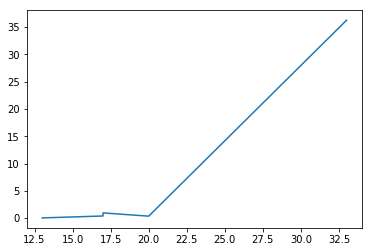

In [308]:
time = [0.0366, 0.3906, 0.9557, 0.3603, 36.2523]
depth = [13, 17, 17, 20, 33]
plt.plot(depth, time)


### IDDFS

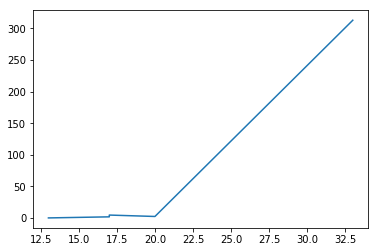

In [309]:
time = [0.1534, 1.8505, 4.6649, 2.4375, 312.8469]
depth = [13, 17, 17, 20, 33]
plt.plot(depth, time)

### A*

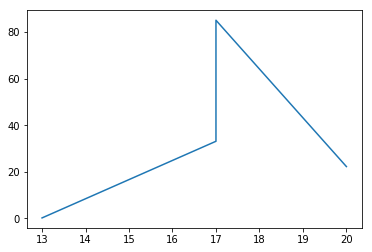

In [310]:
time = [0.2287, 33.1310, 85.0869, 22.2720]
depth = [13, 17, 17, 20]
plt.plot(depth, time)